In [ ]:
import os
import shutil

ROOT_DIR = "/content/drive/MyDrive/Kodingan"
NEW_DATASET_DIR = os.path.join(ROOT_DIR, "dataset_testing_baru_processed")
FINAL_DATASET_DIR = os.path.join(ROOT_DIR, "dataset_testing_final")

# Create the destination directory if it doesn't exist
os.makedirs(FINAL_DATASET_DIR, exist_ok=True)

# Use shutil.copytree to copy the contents
shutil.copytree(NEW_DATASET_DIR, FINAL_DATASET_DIR, dirs_exist_ok=True)

print(f"Contents of '{NEW_DATASET_DIR}' copied to '{FINAL_DATASET_DIR}'")

Contents of '/content/drive/MyDrive/Kodingan/dataset_testing_baru_processed' copied to '/content/drive/MyDrive/Kodingan/dataset_testing_final'


In [ ]:
import os
import pandas as pd
import random
import shutil

# --- CONFIGURATION ---
ROOT_DIR = "/content/drive/MyDrive/Kodingan"
# Path ke dataset ASLI (backup) Anda
ORIGINAL_DATASET_DIR = os.path.join(ROOT_DIR, "dataset_testing_baru_processed")
# Path ke dataset yang sudah terlalu bersih
FINAL_DATASET_DIR = os.path.join(ROOT_DIR, "dataset_testing_final")
# Path ke file label pose kita
POSE_LABELS_CSV = os.path.join(ROOT_DIR, "head_pose_labels.csv")
# Di mana kita akan menyimpan daftar file untuk dipulihkan
SAVE_DIR = os.path.join(ROOT_DIR, "result")

# --- Berapa banyak gambar yang ingin kita kembalikan per kelas ---
NUM_IMAGES_TO_RESTORE_PER_CLASS = 20

# --- Kelas utama kita ---
MAIN_CLASS_NAMES = [
    "Wahyu", "Syahid", "Raiz", "Nurhatinah", "Mahdaniar",
    "Iska", "Erwin", "Bulan", "Amri"
]

def restore_images_by_pose(pose_type="hard"):
    """
    Restores images based on their pose type.

    Args:
        pose_type (str): The type of pose to restore.
                         "hard" for non-'Front, Neutral' poses,
                         "neutral" for 'Front, Neutral' poses.
                         Defaults to "hard".
    """
    print(f"\\n{'='*20} STARTING STRATEGIC IMAGE RESTORATION ({pose_type.upper()} POSES) {'='*20}")

    # --- Step 1: Load pose labels ---
    try:
        pose_df = pd.read_csv(POSE_LABELS_CSV)
        # Buat kolom filename untuk pencocokan yang mudah
        pose_df['filename'] = pose_df['image_path'].apply(os.path.basename)
        pose_df_lookup = pose_df.set_index('filename')
        print("Pose labels loaded successfully.")
    except FileNotFoundError:
        print(f"ERROR: Pose labels file not found at {POSE_LABELS_CSV}.")
        return

    # --- Step 2: Find all deleted files ---
    original_files = set()
    for dirpath, _, filenames in os.walk(ORIGINAL_DATASET_DIR):
        for f in filenames:
            original_files.add(os.path.join(dirpath, f))

    final_files = set()
    for dirpath, _, filenames in os.walk(FINAL_DATASET_DIR):
        for f in filenames:
            final_files.add(os.path.join(dirpath, f))

    original_basenames = {os.path.basename(f): f for f in original_files}
    final_basenames = {os.path.basename(f) for f in final_files}

    deleted_filenames = set(original_basenames.keys()) - final_basenames
    print(f"Found {len(deleted_filenames)} deleted files in total.")

    # --- Step 3: Filter for the specified poses among the deleted files ---
    images_to_restore = []
    for class_name in MAIN_CLASS_NAMES:
        print(f"\\nAnalyzing class: {class_name}")

        deleted_from_class = [fname for fname in deleted_filenames if f"/{class_name}/" in original_basenames[fname]]

        class_orientations = []
        for fname in deleted_from_class:
            try:
                orientation = pose_df_lookup.loc[fname, 'orientation']
                if pose_type == "hard" and orientation != "Front, Neutral":
                    class_orientations.append({'path': original_basenames[fname], 'orientation': orientation})
                elif pose_type == "neutral" and orientation == "Front, Neutral":
                     class_orientations.append({'path': original_basenames[fname], 'orientation': orientation})
            except KeyError:
                continue

        random.shuffle(class_orientations)
        num_to_restore = min(NUM_IMAGES_TO_RESTORE_PER_CLASS, len(class_orientations))

        if num_to_restore > 0:
            print(f"-> Found {len(class_orientations)} deleted '{pose_type}' pose images. Selecting {num_to_restore} to restore.")
            images_to_restore.extend(class_orientations[:num_to_restore])
        else:
            print(f"-> No suitable '{pose_type}' pose images found among the deleted files for this class.")

    # --- Step 4: Automatically restore the marked files ---
    print(f"\\n--- Restoration Plan Complete ---")
    print(f"Total images to restore: {len(images_to_restore)}")

    restored_count = 0
    for item in images_to_restore:
        source_path = item['path']
        relative_path = os.path.relpath(source_path, ORIGINAL_DATASET_DIR)
        dest_path = os.path.join(FINAL_DATASET_DIR, relative_path)

        try:
            # Ensure destination directory exists
            os.makedirs(os.path.dirname(dest_path), exist_ok=True)
            # Use shutil.copy2 to copy the file and its metadata
            shutil.copy2(source_path, dest_path)
            restored_count += 1
        except Exception as e:
            print(f"ERROR: Could not copy {source_path} to {dest_path}. Reason: {e}")

    print(f"\\n✅ Successfully restored {restored_count} images back to the '{os.path.basename(FINAL_DATASET_DIR)}' directory.")

if __name__ == '__main__':
    # Example usage:
    # To restore hard pose images:
    # restore_images_by_pose("hard")
    # To restore neutral pose images:
    restore_images_by_pose("neutral")
    pass # Removed the default call to avoid immediate execution

\n==================== STARTING STRATEGIC IMAGE RESTORATION (NEUTRAL POSES) ====================
Pose labels loaded successfully.
Found 194 deleted files in total.
\nAnalyzing class: Wahyu
-> No suitable 'neutral' pose images found among the deleted files for this class.
\nAnalyzing class: Syahid
-> No suitable 'neutral' pose images found among the deleted files for this class.
\nAnalyzing class: Raiz
-> Found 13 deleted 'neutral' pose images. Selecting 13 to restore.
\nAnalyzing class: Nurhatinah
-> No suitable 'neutral' pose images found among the deleted files for this class.
\nAnalyzing class: Mahdaniar
-> No suitable 'neutral' pose images found among the deleted files for this class.
\nAnalyzing class: Iska
-> No suitable 'neutral' pose images found among the deleted files for this class.
\nAnalyzing class: Erwin
-> No suitable 'neutral' pose images found among the deleted files for this class.
\nAnalyzing class: Bulan
-> No suitable 'neutral' pose images found among the deleted f

In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 32.7 MB/s eta 0:00:00


In [5]:
import pandas as pd
import os

!unzip -q -o "/content/drive/MyDrive/Kodingan/dataset_testing_baru_processed.zip" -d "/content"

def generate_scan_report(csv_file_path):
    """
    Reads a CSV file, checks for image existence, and prints only a
    final summary report of the scan.
    """
    try:
        df = pd.read_csv(csv_file_path)
    except FileNotFoundError:
        print(f"Error: The file '{csv_file_path}' was not found.")
        return

    if 'image_path' not in df.columns:
        print("Error: A column named 'image_path' was not found in the CSV file.")
        return

    print("Scanning files, please wait...")

    found_count = 0
    not_found_count = 0

    for index, row in df.iterrows():
        original_path = row['image_path']
        new_path = original_path.replace(
            "/content/drive/MyDrive/Kodingan/dataset_testing_baru_processed/",
            "/content/dataset_testing_baru_processed/"
        )

        if os.path.exists(new_path):
            found_count += 1
        else:
            not_found_count += 1

    # --- Final Report Output ---
    print("\n" + "="*30)
    print("      Image Scan Report")
    print("="*30)
    print(f"Total Entries Scanned: {len(df)}")
    print(f"✅ Files Found:         {found_count}")
    print(f"❌ Files Missing:       {not_found_count}")
    print("="*30)


if __name__ == "__main__":
    # --- IMPORTANT ---
    # Please replace 'your_file.csv' with the actual name of your CSV file.
    csv_to_check = '/content/drive/MyDrive/Kodingan/head_pose_labels.csv'
    generate_scan_report(csv_to_check)

Scanning files, please wait...

      Image Scan Report
Total Entries Scanned: 1118
✅ Files Found:         1118
❌ Files Missing:       0


In [1]:
import pandas as pd
import os
import shutil
# Using the notebook-specific version of tqdm for a better progress bar in Colab
from tqdm.notebook import tqdm

!unzip -q -o "/content/drive/MyDrive/Kodingan/dataset_testing_baru_processed.zip" -d "/content"

# ==============================================================================
# ✅ 1. CONFIGURE YOUR PATHS HERE
# ==============================================================================
# ⬇️ *** Set the path to your CSV file in the Colab environment.
csv_path = '/content/drive/MyDrive/Kodingan/head_pose_labels.csv'

# ⬇️ *** Set the path for the main output folder where sorted images will be stored.
dest_base_path = '/content/drive/MyDrive/Kodingan/sorted_by_orientation'

# ⬇️ *** Define the old path prefix to be replaced in your CSV file.
old_base_path = '/content/drive/MyDrive/Kodingan/dataset_testing_baru_processed/'

# ⬇️ *** Define the new path prefix where your files are now located in Colab.
new_base_path = '/content/dataset_testing_baru_processed/'
# ==============================================================================


# --- Main Script Logic (No need to edit below this line) ---

print("🚀 Script starting...")

# --- Validate Inputs and Prepare Folders ---
if not os.path.isfile(csv_path):
    print(f"❌ Error: The CSV file was not found at '{csv_path}'.")
    print("Please make sure the path is correct in the configuration section.")
else:
    # Create the base destination directory if it doesn't exist
    os.makedirs(dest_base_path, exist_ok=True)
    print(f"👍 Destination folder is ready at: '{dest_base_path}'")

    # --- Load Data from CSV ---
    try:
        print(f"📄 Reading data from {os.path.basename(csv_path)}...")
        df = pd.read_csv(csv_path)

        # Check if required columns exist
        if 'image_path' not in df.columns or 'orientation' not in df.columns:
             print("❌ Error: The CSV file must contain 'image_path' and 'orientation' columns.")
        else:
            # --- Processing Loop ---
            print("⏳ Starting to sort and copy images...")

            # Use tqdm for a nice progress bar
            for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Images"):
                original_path_from_csv = row['image_path']
                orientation = row['orientation']

                # ✅ 2. CORRECT THE IMAGE PATH
                #    This replaces the old Drive path with the new local Colab path.
                corrected_source_path = original_path_from_csv.replace(old_base_path, new_base_path)

                # Check if the corrected source file exists before trying to copy
                if not os.path.exists(corrected_source_path):
                    # Print a warning for the first few missing files, then suppress to avoid clutter
                    if 'missing_files_count' not in locals(): missing_files_count = 0
                    if missing_files_count < 5:
                        print(f"\n⚠️ Warning: Source image not found, skipping: {corrected_source_path}")
                    elif missing_files_count == 5:
                        print("\n⚠️ (Suppressing further 'file not found' warnings...)")
                    missing_files_count += 1
                    continue # Skip to the next row

                # Sanitize the orientation label to create a valid folder name
                folder_name = orientation.replace(", ", "_").replace(" ", "_")

                # Create the orientation-specific folder if it doesn't already exist
                orientation_folder_path = os.path.join(dest_base_path, folder_name)
                os.makedirs(orientation_folder_path, exist_ok=True)

                # Copy the file from the source to the new destination
                try:
                    shutil.copy(corrected_source_path, orientation_folder_path)
                except Exception as e:
                    print(f"\n❌ Error copying file {corrected_source_path}: {e}")

            print(f"\n🎉 All done! Images have been successfully sorted into subfolders inside '{dest_base_path}'")

    except Exception as e:
        print(f"\n❌ An error occurred while reading the CSV file: {e}")

🚀 Script starting...
👍 Destination folder is ready at: '/content/drive/MyDrive/Kodingan/sorted_by_orientation'
📄 Reading data from head_pose_labels.csv...
⏳ Starting to sort and copy images...


Processing Images:   0%|          | 0/1118 [00:00<?, ?it/s]


🎉 All done! Images have been successfully sorted into subfolders inside '/content/drive/MyDrive/Kodingan/sorted_by_orientation'


In [1]:
import os
import pandas as pd
from tqdm.notebook import tqdm

!unzip -q -o "/content/drive/MyDrive/Kodingan/sorted_by_orientation_fixed.zip" -d "/content"

# ==============================================================================
# ✅ 1. CONFIGURE YOUR PATHS HERE
# ==============================================================================
# ⬇️ *** Set the path to the folder containing your sorted image subfolders.
source_folder = '/content/sorted_by_orientation_fixed'

# ⬇️ *** Set the desired name and path for your new output CSV file.
output_csv_path = '/content/drive/MyDrive/Kodingan/new_orientation_labels.csv'
# ==============================================================================


# --- Main Script Logic (No need to edit below this line) ---

print("🚀 Script starting...")

# A list to hold the data before we create the DataFrame
image_data = []

# --- Validate Source Folder ---
if not os.path.isdir(source_folder):
    print(f"❌ Error: The source folder was not found at '{source_folder}'.")
    print("Please make sure the path is correct in the configuration section.")
else:
    print(f"📂 Scanning folder: '{source_folder}'")

    # os.walk is perfect for iterating through a directory tree
    # It provides the directory path, a list of subdirectories, and a list of files
    for dirpath, dirnames, filenames in tqdm(list(os.walk(source_folder)), desc="Scanning Subfolders"):

        # We only care about the subfolders, not the top-level directory itself
        if dirpath != source_folder:

            # The orientation is the name of the subfolder
            # os.path.basename gets the last part of the path (the folder name)
            orientation_label = os.path.basename(dirpath)

            # Loop through all the files found in that subfolder
            for file in filenames:
                # Add a record for each file to our list
                image_data.append({
                    'file_name': file,
                    'orientation': orientation_label
                })

    # --- Create and Save the CSV File ---
    if not image_data:
        print("\n⚠️ Warning: No image files were found in the subfolders.")
    else:
        print(f"\n✅ Found {len(image_data)} images in total.")
        print("✍️ Creating DataFrame and saving to CSV...")

        # Create a pandas DataFrame from our list of dictionaries
        df = pd.DataFrame(image_data)

        # Save the DataFrame to a CSV file
        # index=False prevents pandas from writing row numbers into the file
        df.to_csv(output_csv_path, index=False)

        print(f"\n🎉 Success! New CSV file created at: {output_csv_path}")

        # Display the first few rows of the new DataFrame as a preview
        print("\n🔍 Preview of your new CSV file:")
        print(df.head())

🚀 Script starting...
📂 Scanning folder: '/content/sorted_by_orientation_fixed'


Scanning Subfolders:   0%|          | 0/10 [00:00<?, ?it/s]


✅ Found 1063 images in total.
✍️ Creating DataFrame and saving to CSV...

🎉 Success! New CSV file created at: /content/drive/MyDrive/Kodingan/new_orientation_labels.csv

🔍 Preview of your new CSV file:
                                           file_name orientation
0  Erwin_1M_2_mp4-0060_jpg.rf.204665f289867f3c9e1...    Right_Up
1  Bulan_1M_2_mp4-0033_jpg.rf.81856ef67a9573dd8c7...    Right_Up
2  Erwin_1M_2_mp4-0065_jpg.rf.78a81f334e257f2c240...    Right_Up
3  Erwin_1M_2_mp4-0057_jpg.rf.655a82ffdff193dd955...    Right_Up
4  Bulan_1M_2_mp4-0036_jpg.rf.132c8aa4b875130a081...    Right_Up


📄 Reading data from '/content/drive/MyDrive/Kodingan/new_orientation_labels.csv'...

🔍 Numerical Distribution of Images per Orientation:
orientation
Front_Neutral    405
Left_Neutral     170
Right_Neutral    142
Front_Down        83
Left_Down         72
Right_Down        59
Front_Up          46
Left_Up           44
Right_Up          42
Name: count, dtype: int64

📊 Generating visualization...


/tmp/ipython-input-1173086105.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


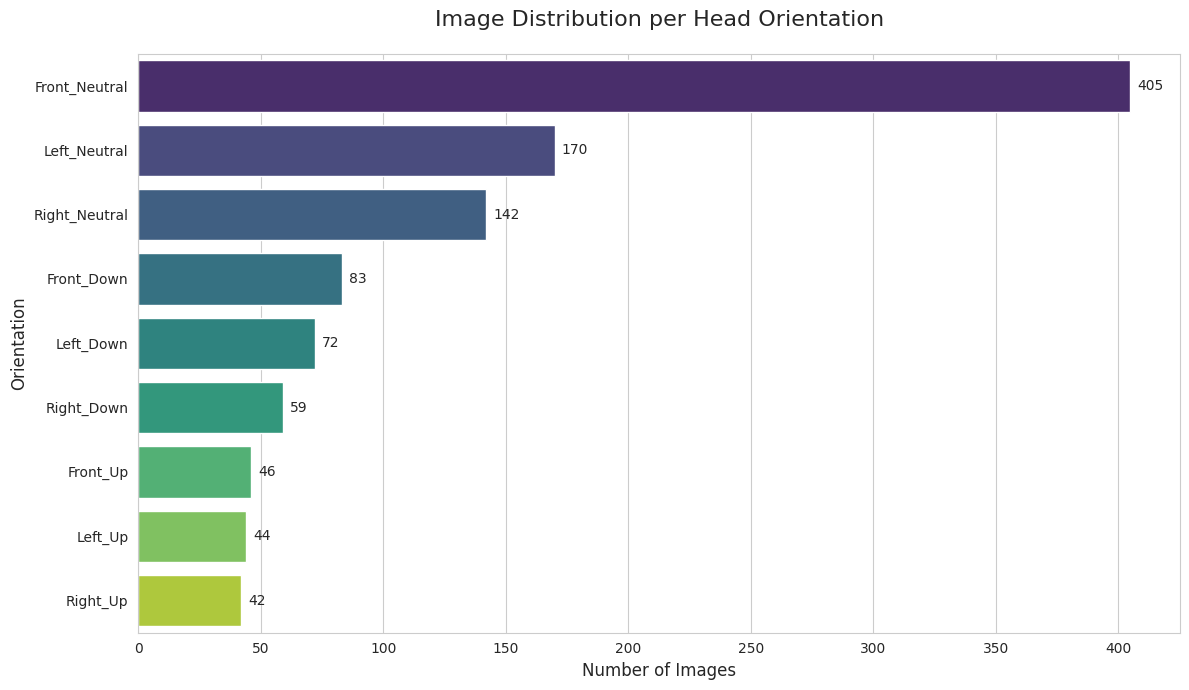

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ==============================================================================
# ✅ 1. CONFIGURE YOUR CSV FILE PATH HERE
# ==============================================================================
# ⬇️ *** Set the path to the CSV file you just created.
csv_path = '/content/drive/MyDrive/Kodingan/new_orientation_labels.csv'
# ==============================================================================


# --- Main Script Logic (No need to edit below this line) ---

# --- Validate CSV file path ---
if not os.path.isfile(csv_path):
    print(f"❌ Error: The CSV file was not found at '{csv_path}'.")
    print("Please make sure the path is correct and you have run the previous script.")
else:
    # Load the dataset from the CSV file
    print(f"📄 Reading data from '{csv_path}'...")
    df = pd.read_csv(csv_path)

    # --- 1. Show Numerical Distribution ---
    print("\n🔍 Numerical Distribution of Images per Orientation:")
    # value_counts() is a fast way to count unique values in a column
    orientation_counts = df['orientation'].value_counts()
    print(orientation_counts)

    # --- 2. Show Visual Distribution (Bar Chart) ---
    print("\n📊 Generating visualization...")

    # Set the visual style of the plots
    sns.set_style("whitegrid")

    # Create a figure with a specific size to make sure labels fit well
    plt.figure(figsize=(12, 7))

    # Create the count plot (a bar chart showing counts of categories)
    # We use y='orientation' to create a horizontal bar chart, which is easier to read with long labels.
    ax = sns.countplot(
        data=df,
        y='orientation',
        order=orientation_counts.index,  # Order bars from most to least common
        palette='viridis' # Using a pleasant color scheme
    )

    # Add labels and a title for clarity
    ax.set_title('Image Distribution per Head Orientation', fontsize=16, pad=20)
    ax.set_xlabel('Number of Images', fontsize=12)
    ax.set_ylabel('Orientation', fontsize=12)

    # Add the exact count at the end of each bar for better readability
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', padding=5)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [1]:
!unzip -q -o "/content/drive/MyDrive/Kodingan/dataset_processed.zip" -d "/content"
!unzip -q -o "/content/drive/MyDrive/Kodingan/best_testing.zip" -d "/content"
import os

def count_and_display_stats(directory_path, dataset_name):
    """
    Menghitung dan menampilkan jumlah file per subdirektori (kelas)
    dan total file dalam sebuah direktori.
    """
    print(f"--- Menganalisis Dataset: {dataset_name} ---")
    print(f"Lokasi: {directory_path}\n")

    if not os.path.isdir(directory_path):
        print("!!! Error: Direktori tidak ditemukan. Pastikan perintah unzip berhasil.\n")
        return

    class_counts = {}
    total_files = 0

    # Mengambil daftar subdirektori (nama kelas) dan mengurutkannya
    try:
        subdirectories = sorted(os.listdir(directory_path))
    except FileNotFoundError:
        print("!!! Error: Direktori tidak ditemukan saat diakses.\n")
        return

    # Iterasi melalui setiap kelas untuk menghitung file
    for class_name in subdirectories:
        class_path = os.path.join(directory_path, class_name)
        if os.path.isdir(class_path):
            # Menghitung hanya file, mengabaikan folder lain jika ada
            num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_files
            total_files += num_files

    # Menampilkan hasil perhitungan
    if not class_counts:
        print("Tidak ada subdirektori (kelas) yang ditemukan di dalam direktori ini.\n")
        return

    print("📊 Jumlah Data per Kelas:")
    for class_name, count in class_counts.items():
        print(f"  - {class_name:<15}: {count} file")

    print("-" * 30)
    print(f"Total Semua Data: {total_files} file")
    print("\n" + "="*40 + "\n")


# --- Path Direktori Anda ---
# Skrip ini mengasumsikan Anda sudah menjalankan !unzip
DATA_DIR = '/content/dataset_processed'
TEST_DIR = '/content/best_testing'

# --- Menjalankan Fungsi ---
count_and_display_stats(DATA_DIR, "Gallery (dataset_processed)")
count_and_display_stats(TEST_DIR, "Probe (best_testing)")

--- Menganalisis Dataset: Gallery (dataset_processed) ---
Lokasi: /content/dataset_processed

📊 Jumlah Data per Kelas:
  - Amri           : 88 file
  - Bulan          : 91 file
  - Erwin          : 94 file
  - Iska           : 100 file
  - Mahdaniar      : 57 file
  - Nurhatinah     : 74 file
  - Raiz           : 100 file
  - Syahid         : 117 file
  - Wahyu          : 118 file
  - class_01       : 12 file
  - class_02       : 12 file
  - class_03       : 12 file
  - class_04       : 12 file
  - class_05       : 12 file
  - class_06       : 12 file
  - class_07       : 12 file
  - class_08       : 12 file
  - class_09       : 12 file
  - class_10       : 12 file
  - class_11       : 12 file
  - class_12       : 12 file
  - class_13       : 12 file
  - class_14       : 12 file
  - class_15       : 12 file
  - class_16       : 12 file
  - class_17       : 12 file
  - class_18       : 12 file
  - class_19       : 12 file
  - class_20       : 12 file
  - class_21       : 12 file
  - cla